# Goal:

In this assignment, you will implement the self-supervised contrastive learning algorithm, [SimCLR](https://arxiv.org/abs/2002.05709), using PyTorch. You will use the STL-10 dataset for this assignment.

You need to compete the `Net` class definition, the `SimCLRDataset` dataset class definition and the SimCLR loss in the `Trainer` class. You need to run the training loop, save the best training model and evaluate using the `linear probe` classfication task. Since we don't have enough GPU resources and contrastive learning algorithm like SimCLR usually needs around `1000` epoches to train (we only have `70` epoches), you may not get the best performance. Thus, as for the performance side, as long as you see the loss is decreasing (to around 7.4 at `70` epoch) and the accuracy is increasing, you are good to go.

Grade:

- **Fill the Net class definition (5 points).**
- **Fill the SimCLRDataset dataset class definition (10 points).**
- **Fill the SimCLR loss in the Trainer class (20 points).**
- **Record the training loss within 70 epochs, the lower the better (5 points).**
- **Record the linear probe accuracy, the higher the better (5 points).**
- **Write a report including:**
  - **How you select data augmentation (transform) in the transform pool.**
  - **How you implement the SimCLR loss and explain why your SimCLR loss is computationally efficient and equivalent to the loss function in the paper.**
  - **Include the training loss curve and the downstream accuracy (15 points). Note that the logging logic is not provided, please implement them before you start training.**
---
Please DO NOT change the config provided. Only change the given code if you are confident that the change is necessary. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider to use Kaggle GPU resource. Thank you and good luck!

# Self-supervised learning: SimCLR

Self-supervised learning

1.   Design an auxiliary task.
2.   Train the base network on the auxiliary task.
3.   Evaluate on the down-stream task: Train a new decoder based on the trained encoder.

Specifically, as one of the most successful self-supervised learning algorithm, SimCLR, a contrastive learning algorithm is what we focus today. Below, we are going to implement SimCLR as an example of self-supervised learning.


<img src="https://camo.githubusercontent.com/35af3432fbe91c56a934b5ee58931b4848ab35043830c9dd6f08fa41e6eadbe7/68747470733a2f2f312e62702e626c6f6773706f742e636f6d2f2d2d764834504b704539596f2f586f3461324259657276492f414141414141414146704d2f766146447750584f79416f6b4143385868383532447a4f67457332324e68625877434c63424741735948512f73313630302f696d616765342e676966" width="650" height="650">

In [1]:
# Config
# Since, we are using jupyter notebook, we use easydict to micic argparse. Feel free to use other format of config
from easydict import EasyDict
import torch.nn as nn
from tqdm import tqdm
import torch
from collections import OrderedDict
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path

config = {
    'dataset_name': 'stl10',
    'workers': 1,
    'epochs': 70,
    'batch_size': 3072, #3072
    'lr': 0.0003,
    'weight_decay': 1e-4,
    'seed': 4242,
    'fp16_precision': True,
    'out_dim': 128,
    'temperature': 0.5,
    'n_views': 2,
    'device': "cuda" if torch.cuda.is_available() else "cpu",
}
args = EasyDict(config)

We are going to use [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/).

<img src="https://cs.stanford.edu/~acoates/stl10/images.png" width="450" height="450">

Overview

*   10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
*   Images are **96x96** pixels, color.
*   500 training images (10 pre-defined folds), 800 test images per class.
*   100000 unlabeled images for unsupervised learning. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
*   Images were acquired from labeled examples on ImageNet.


## Preparation

Define a ResNet-18 and an additional MLP layer as the model training in the auxiliary task.

In [2]:
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.basemodel = models.resnet18(pretrained=False, num_classes=args.out_dim)
        self.fc_in_features = self.basemodel.fc.in_features
        self.backup_fc = None
        # ToDO: define an MLP layer to insert between the last layer and the rest of the model
        self.basemodel.fc = nn.Sequential(OrderedDict([
            ('ssl_mlp_linear', nn.Linear(self.fc_in_features, self.fc_in_features)),
            ('ssl_mlp_relu', nn.ReLU()),
            ('basemodel_fc_orig', self.basemodel.fc)
        ]))

    def forward(self, x):
        # ToDo: implement the forward logic
        return self.basemodel(x)

    def linear_probe(self):
        self.freeze_basemodel_encoder()
        self.backup_fc = self.basemodel.fc  # Backup the last Linear layer
        # ToDo: implement the linear probe for your downstream task. A linear prob is just a linear layer (not MLP, no activation layer included) after the learned encoder.
        self.basemodel.fc = nn.Sequential(OrderedDict([
            ('linear_probe', nn.Linear(self.fc_in_features, 10)),
        ]))

    def restore_backbone(self):
        self.basemodel.fc = self.backup_fc
        self.backup_fc = None

    def freeze_basemodel_encoder(self):
        # do not freeze the self.basemodel.fc weights
        for name, param in self.basemodel.named_parameters():
            if 'fc' not in name:
                param.requires_grad = False

# Step 1: Design the auxiliary task.
## construct the dataset

In [3]:
from torchvision import transforms, datasets

class View_sampler(object):
    """This class randomly sample two transforms from the list of transforms for the SimCLR to use. It is used in the SimCLRDataset.get_dataset."""

    def __init__(self, transforms, n_views=2):
        self.transforms = transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.transforms(x) for i in range(self.n_views)]


class SimCLRDataset:
    def __init__(self, root_folder="./datasets"):
        self.root_folder = root_folder

    @staticmethod
    def transforms_pool():
        # ToDo
        IMAGE_SIZE = 96
        random_crop = transforms.RandomResizedCrop(size=(IMAGE_SIZE,IMAGE_SIZE), scale=(0.08, 1.0), ratio=(3. / 4., 4. / 3.))
        rand_flip = transforms.RandomHorizontalFlip(p=0.5)
        def get_color_distortion(s=1.0):
            # s is the strength of color distortion.
            color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
            random_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
            random_gray = transforms.RandomGrayscale(p=0.2)
            color_distort = transforms.Compose([
                random_color_jitter,
                random_gray
            ])
            return color_distort

        color_distortion = get_color_distortion(s=1.0)

        gaussian_blur = transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=0.1*IMAGE_SIZE, sigma=(0.1,2.0)
        )], p=0.5)


        data_transforms = transforms.Compose([
            random_crop,
            rand_flip,
            color_distortion,
            gaussian_blur,
            transforms.ToTensor(),
        ])
        #data_transforms = transforms.Compose([...]) # for example, you can use RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomGrayscale, GaussianBlur, ToTensor (compulsory), Normalize (), etc.
        return data_transforms

    def get_dataset(self):
        dataset_fn = lambda: datasets.STL10(self.root_folder, split='unlabeled', transform=View_sampler(self.transforms_pool(), 2), download=True)
        return dataset_fn()

## Define dataloader, optimizer and scheduler

What is a scheduler?

A scheduler helps in optimizing the convergence, avoiding local minima, and potentially improving the model's performance on the task at hand. The learning rate is one of the most important hyperparameters for training neural networks, and finding an appropriate learning rate schedule can be crucial for your model's success.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*qe6nYlH8zsmUdScyHMhRCQ.png" width="1200" height="450">

Read more here: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [4]:
model = Net()
dataset = SimCLRDataset()
#train_dataset = dataset.get_dataset(args.dataset_name, args.n_views)
train_dataset = dataset.get_dataset()

# ToDo, define dataloader based on the train_dataset with drop_last=True
dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, drop_last=True)
# ToDo, define an optimizer with args.lr as the learning rate and args.weight_decay as the weight_decay
optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# ToDo, define an lr_scheduler CosineAnnealingLR for the optimizer
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader), eta_min=0, last_epoch=-1)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Files already downloaded and verified


# Define the trainer


Automatic Mixed Precision (AMP) is a technique that aims to improve the speed and efficiency of training deep neural networks by leveraging mixed-precision training.

**Introduction to AMP**

AMP allows neural network training to use both single-precision (FP32) and half-precision (FP16) floating point arithmetic simultaneously. The main idea behind AMP is to perform certain operations in FP16 to exploit the faster arithmetic and reduced memory usage of lower-precision computing, while maintaining the critical parts of the computation in FP32 to ensure model accuracy and stability.

**Why We Cannot Always Use FP16**



*   **Numerical Stability**: FP16 has a smaller dynamic range and lower precision compared to FP32. This limitation can lead to numerical instability, such as underflows and overflows, particularly during operations that involve small gradient values or require high numerical precision. This can adversely affect the convergence and accuracy of the trained model.
*   **Selective Precision Requirements**: Certain operations and layers within neural networks are more sensitive to precision than others. For example, weight updates in optimizers might require FP32 to maintain accuracy over time. AMP strategies, therefore, involve selectively applying FP16 to parts of the computation where it can be beneficial without undermining the overall training process.

Below, we present how to include AMP logic in standard torch training procedure.

Before including AMP:
```python
for batch in data_loader:
    # Forward pass
    inputs, targets = batch
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

After including AMP:
```python
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

for batch in data_loader:
    inputs, targets = batch[0].cuda(), batch[1].cuda()

    # Forward pass
    with autocast():
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

    # Backward pass and optimize
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
```


Read more here: https://pytorch.org/docs/stable/amp.html

## Implement loss function in the Trainer
The algorithm of SimCLR Loss function is as follows:
$$
\begin{aligned}
&\text{for all } i \in \{1, \ldots, 2N\} \text{ and } j \in \{1, \ldots, 2N\} \text{ do} \\
&\quad s_{i,j} = \frac{z_i^\top z_j}{\|z_i\|\|z_j\|} \quad \text{# pairwise similarity} \\
&\text{end for} \\
&\text{define } \ell(i,j) \text{ as } \ell(i,j) = -\log \left( \frac{\exp(s_{i,j} / \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq j]} \exp(s_{i,k} / \tau)} \right) \\
&\mathcal{L} = \frac{1}{2N} \sum_{k=1}^{N} \left[\ell(2k-1, 2k) + \ell(2k, 2k-1)\right] \\
&\text{update networks } f \text{ and } g \text{ to minimize } \mathcal{L}
\end{aligned}
$$

Please fill the blanks in the loss function below. Hint: implement mask to avoid including self-self similarity, and postive pairs and negative pairs.

In [5]:
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast


class Trainer():
    def __init__(self, *args, **kwargs):
        self.args = kwargs['args']
        self.model = kwargs['model'].to(self.args.device)
        self.optimizer = kwargs['optimizer']
        self.scheduler = kwargs['scheduler']
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)

    def loss(self, features):
        # Input features is a torch tensor with shape of (2*batch_size, out_dim)
        # Re-arrange the `features` tensor according to the SimCLR convention

        batch_size = features.size(0) // 2

        # # Réarranger les caractéristiques pour alterner les paires positives (Z_{2k-1}, Z_{2k})
        new_features = torch.empty_like(features)
        new_features[0::2] = features[:batch_size]
        new_features[1::2] = features[batch_size:]

        # Calculer la similarité cosinus à partir de zéro
        # Normaliser les caractéristiques à une longueur unitaire
        norm_features = F.normalize(new_features, p=2, dim=1)
        # Calculer la similarité cosinus en utilisant la multiplication matricielle
        sim_matrix = torch.matmul(norm_features, norm_features.T) / self.args.temperature

        # Générer des étiquettes pour la perte de l'entropie croisée, des indices alternés pour les paires positives
        target = torch.arange(0, 2 * batch_size, device=features.device)
        target[0::2] += 1
        target[1::2] -= 1

        # Définir la diagonale sur -inf pour éviter l'auto-comparaison
        sim_matrix.fill_diagonal_(float('-inf'))

        # # Calcul de la Cross-entropy
        loss = F.cross_entropy(sim_matrix, target, reduction='mean')
        return loss

    def train(self, dataloader):
        # implement GradScaler if AMP
        best_loss = 1e4
        scaler = GradScaler(enabled=self.args.fp16_precision)
        losses = []
        for epoch in range(self.args.epochs):
            for images, _ in tqdm(dataloader, desc=f'SSL_pretraining_epoch_{epoch}/{self.args.epochs}'):
                images = torch.cat(images, dim=0)
                images = images.to(self.args.device)

                with autocast(enabled=self.args.fp16_precision):
                    features = self.model(images)
                    loss = self.loss(features)
                    losses.append(loss.item())

                # features = self.model(images)
                # loss = self.loss(features)
                self.optimizer.zero_grad()

                scaler.scale(loss).backward()
                scaler.step(self.optimizer)
                scaler.update()

                # loss.backward()
                # self.optimizer.step()
                self.scheduler.step()

            # warmup for the first 10 epochs
            if epoch >= 10:
                self.scheduler.step()
            if epoch % 10 == 0 and epoch != 0:
                self.save_model(self.model, f"model_{epoch}.pth")
            # save the lowest loss model
            # feel free to implement your own logic to save the best model
            if loss < best_loss:
                best_loss = loss
                self.save_model(self.model, f"best_model.pth")
            print(f"Epoch {epoch}, Loss {loss.item()}")
        return self.model, losses

    def save_model(self, model, path):
        torch.save(model.state_dict(), path)

# Step 2: Train the base network on the auxiliary task for 70 epoch and save the best model you have for evaluation.

Check if the training loss drops over time and try to capture other possible bug using logging tools. Each epoch should take around 7 minutes. The loss should be expected to around 7.4.

In [7]:
trainer = Trainer(args=args, model=model, optimizer=optimizer, scheduler=lr_scheduler)
model_SimCLR, ssl_losses = trainer.train(dataloader)

SSL_pretraining_epoch_0/70:   0%|          | 0/32 [00:00<?, ?it/s]

SSL_pretraining_epoch_0/70: 100%|██████████| 32/32 [09:06<00:00, 17.06s/it]


Epoch 0, Loss 8.237573623657227


SSL_pretraining_epoch_1/70: 100%|██████████| 32/32 [09:04<00:00, 17.03s/it]


Epoch 1, Loss 8.087926864624023


SSL_pretraining_epoch_2/70: 100%|██████████| 32/32 [09:05<00:00, 17.03s/it]


Epoch 2, Loss 7.918576717376709


SSL_pretraining_epoch_3/70: 100%|██████████| 32/32 [09:08<00:00, 17.13s/it]


Epoch 3, Loss 7.870461940765381


SSL_pretraining_epoch_4/70: 100%|██████████| 32/32 [09:12<00:00, 17.27s/it]


Epoch 4, Loss 7.795377254486084


SSL_pretraining_epoch_5/70: 100%|██████████| 32/32 [09:08<00:00, 17.14s/it]


Epoch 5, Loss 7.815479755401611


SSL_pretraining_epoch_6/70: 100%|██████████| 32/32 [09:08<00:00, 17.13s/it]


Epoch 6, Loss 7.749228000640869


SSL_pretraining_epoch_7/70: 100%|██████████| 32/32 [09:18<00:00, 17.46s/it]


Epoch 7, Loss 7.768814563751221


SSL_pretraining_epoch_8/70: 100%|██████████| 32/32 [08:59<00:00, 16.86s/it]


Epoch 8, Loss 7.6773362159729


SSL_pretraining_epoch_9/70: 100%|██████████| 32/32 [09:00<00:00, 16.88s/it]


Epoch 9, Loss 7.703441619873047


SSL_pretraining_epoch_10/70: 100%|██████████| 32/32 [09:12<00:00, 17.25s/it]


Epoch 10, Loss 7.647228240966797


SSL_pretraining_epoch_11/70: 100%|██████████| 32/32 [09:14<00:00, 17.31s/it]


Epoch 11, Loss 7.686811447143555


SSL_pretraining_epoch_12/70: 100%|██████████| 32/32 [09:10<00:00, 17.21s/it]


Epoch 12, Loss 7.651692867279053


SSL_pretraining_epoch_13/70: 100%|██████████| 32/32 [09:17<00:00, 17.44s/it]


Epoch 13, Loss 7.652709484100342


SSL_pretraining_epoch_14/70: 100%|██████████| 32/32 [09:14<00:00, 17.32s/it]


Epoch 14, Loss 7.625785827636719


SSL_pretraining_epoch_15/70: 100%|██████████| 32/32 [09:12<00:00, 17.26s/it]


Epoch 15, Loss 7.649738311767578


SSL_pretraining_epoch_16/70: 100%|██████████| 32/32 [09:06<00:00, 17.09s/it]


Epoch 16, Loss 7.587728977203369


SSL_pretraining_epoch_17/70: 100%|██████████| 32/32 [09:04<00:00, 17.02s/it]


Epoch 17, Loss 7.643821716308594


SSL_pretraining_epoch_18/70: 100%|██████████| 32/32 [09:12<00:00, 17.27s/it]


Epoch 18, Loss 7.587284564971924


SSL_pretraining_epoch_19/70: 100%|██████████| 32/32 [09:08<00:00, 17.13s/it]


Epoch 19, Loss 7.630616664886475


SSL_pretraining_epoch_20/70: 100%|██████████| 32/32 [09:09<00:00, 17.16s/it]


Epoch 20, Loss 7.566425800323486


SSL_pretraining_epoch_21/70: 100%|██████████| 32/32 [09:00<00:00, 16.91s/it]


Epoch 21, Loss 7.570899486541748


SSL_pretraining_epoch_22/70: 100%|██████████| 32/32 [09:05<00:00, 17.04s/it]


Epoch 22, Loss 7.563022136688232


SSL_pretraining_epoch_23/70: 100%|██████████| 32/32 [09:04<00:00, 17.02s/it]


Epoch 23, Loss 7.583057403564453


SSL_pretraining_epoch_24/70: 100%|██████████| 32/32 [09:20<00:00, 17.51s/it]


Epoch 24, Loss 7.540504455566406


SSL_pretraining_epoch_25/70: 100%|██████████| 32/32 [09:20<00:00, 17.53s/it]


Epoch 25, Loss 7.542704105377197


SSL_pretraining_epoch_26/70: 100%|██████████| 32/32 [09:28<00:00, 17.77s/it]


Epoch 26, Loss 7.539180755615234


SSL_pretraining_epoch_27/70: 100%|██████████| 32/32 [09:17<00:00, 17.44s/it]


Epoch 27, Loss 7.54511833190918


SSL_pretraining_epoch_28/70: 100%|██████████| 32/32 [09:03<00:00, 16.99s/it]


Epoch 28, Loss 7.5247673988342285


SSL_pretraining_epoch_29/70: 100%|██████████| 32/32 [09:07<00:00, 17.11s/it]


Epoch 29, Loss 7.510241985321045


SSL_pretraining_epoch_30/70: 100%|██████████| 32/32 [09:12<00:00, 17.28s/it]


Epoch 30, Loss 7.504160404205322


SSL_pretraining_epoch_31/70: 100%|██████████| 32/32 [08:58<00:00, 16.84s/it]


Epoch 31, Loss 7.507847309112549


SSL_pretraining_epoch_32/70: 100%|██████████| 32/32 [08:01<00:00, 15.05s/it]


Epoch 32, Loss 7.504726409912109


SSL_pretraining_epoch_33/70: 100%|██████████| 32/32 [08:25<00:00, 15.81s/it]


Epoch 33, Loss 7.50585412979126


SSL_pretraining_epoch_34/70: 100%|██████████| 32/32 [08:47<00:00, 16.48s/it]


Epoch 34, Loss 7.525539875030518


SSL_pretraining_epoch_35/70: 100%|██████████| 32/32 [08:42<00:00, 16.32s/it]


Epoch 35, Loss 7.484403133392334


SSL_pretraining_epoch_36/70: 100%|██████████| 32/32 [08:52<00:00, 16.65s/it]


Epoch 36, Loss 7.508239269256592


SSL_pretraining_epoch_37/70: 100%|██████████| 32/32 [08:28<00:00, 15.91s/it]


Epoch 37, Loss 7.494594097137451


SSL_pretraining_epoch_38/70: 100%|██████████| 32/32 [07:55<00:00, 14.86s/it]


Epoch 38, Loss 7.503790378570557


SSL_pretraining_epoch_39/70: 100%|██████████| 32/32 [07:57<00:00, 14.92s/it]


Epoch 39, Loss 7.460521697998047


SSL_pretraining_epoch_40/70: 100%|██████████| 32/32 [08:07<00:00, 15.25s/it]


Epoch 40, Loss 7.481350421905518


SSL_pretraining_epoch_41/70: 100%|██████████| 32/32 [09:06<00:00, 17.08s/it]


Epoch 41, Loss 7.464565753936768


SSL_pretraining_epoch_42/70: 100%|██████████| 32/32 [09:06<00:00, 17.07s/it]


Epoch 42, Loss 7.495987415313721


SSL_pretraining_epoch_43/70: 100%|██████████| 32/32 [09:07<00:00, 17.11s/it]


Epoch 43, Loss 7.465174198150635


SSL_pretraining_epoch_44/70: 100%|██████████| 32/32 [09:08<00:00, 17.13s/it]


Epoch 44, Loss 7.499368190765381


SSL_pretraining_epoch_45/70: 100%|██████████| 32/32 [09:08<00:00, 17.14s/it]


Epoch 45, Loss 7.438474178314209


SSL_pretraining_epoch_46/70: 100%|██████████| 32/32 [09:18<00:00, 17.44s/it]


Epoch 46, Loss 7.471471309661865


SSL_pretraining_epoch_47/70: 100%|██████████| 32/32 [09:12<00:00, 17.26s/it]


Epoch 47, Loss 7.439822673797607


SSL_pretraining_epoch_48/70: 100%|██████████| 32/32 [09:15<00:00, 17.35s/it]


Epoch 48, Loss 7.458255767822266


SSL_pretraining_epoch_49/70: 100%|██████████| 32/32 [09:05<00:00, 17.06s/it]


Epoch 49, Loss 7.4293437004089355


SSL_pretraining_epoch_50/70: 100%|██████████| 32/32 [09:06<00:00, 17.07s/it]


Epoch 50, Loss 7.4805827140808105


SSL_pretraining_epoch_51/70: 100%|██████████| 32/32 [09:06<00:00, 17.07s/it]


Epoch 51, Loss 7.430385112762451


SSL_pretraining_epoch_52/70: 100%|██████████| 32/32 [09:08<00:00, 17.15s/it]


Epoch 52, Loss 7.456510543823242


SSL_pretraining_epoch_53/70: 100%|██████████| 32/32 [09:17<00:00, 17.41s/it]


Epoch 53, Loss 7.424253463745117


SSL_pretraining_epoch_54/70: 100%|██████████| 32/32 [08:59<00:00, 16.85s/it]


Epoch 54, Loss 7.451659679412842


SSL_pretraining_epoch_55/70: 100%|██████████| 32/32 [08:38<00:00, 16.20s/it]


Epoch 55, Loss 7.417425155639648


SSL_pretraining_epoch_56/70: 100%|██████████| 32/32 [08:38<00:00, 16.20s/it]


Epoch 56, Loss 7.441776275634766


SSL_pretraining_epoch_57/70: 100%|██████████| 32/32 [08:40<00:00, 16.28s/it]


Epoch 57, Loss 7.403287410736084


SSL_pretraining_epoch_58/70: 100%|██████████| 32/32 [08:40<00:00, 16.28s/it]


Epoch 58, Loss 7.429002285003662


SSL_pretraining_epoch_59/70: 100%|██████████| 32/32 [08:41<00:00, 16.31s/it]


Epoch 59, Loss 7.420319080352783


SSL_pretraining_epoch_60/70: 100%|██████████| 32/32 [08:40<00:00, 16.27s/it]


Epoch 60, Loss 7.4350128173828125


SSL_pretraining_epoch_61/70: 100%|██████████| 32/32 [08:37<00:00, 16.18s/it]


Epoch 61, Loss 7.413501739501953


SSL_pretraining_epoch_62/70: 100%|██████████| 32/32 [08:17<00:00, 15.53s/it]


Epoch 62, Loss 7.426525592803955


SSL_pretraining_epoch_63/70: 100%|██████████| 32/32 [08:50<00:00, 16.57s/it]


Epoch 63, Loss 7.40080451965332


SSL_pretraining_epoch_64/70: 100%|██████████| 32/32 [08:47<00:00, 16.48s/it]


Epoch 64, Loss 7.407121658325195


SSL_pretraining_epoch_65/70: 100%|██████████| 32/32 [09:15<00:00, 17.36s/it]


Epoch 65, Loss 7.417503833770752


SSL_pretraining_epoch_66/70: 100%|██████████| 32/32 [09:24<00:00, 17.65s/it]


Epoch 66, Loss 7.410979747772217


SSL_pretraining_epoch_67/70: 100%|██████████| 32/32 [09:06<00:00, 17.09s/it]


Epoch 67, Loss 7.394552230834961


SSL_pretraining_epoch_68/70: 100%|██████████| 32/32 [08:48<00:00, 16.51s/it]


Epoch 68, Loss 7.383052349090576


SSL_pretraining_epoch_69/70: 100%|██████████| 32/32 [09:23<00:00, 17.62s/it]


Epoch 69, Loss 7.39124059677124


NameError: name 'ssl_losses' is not defined

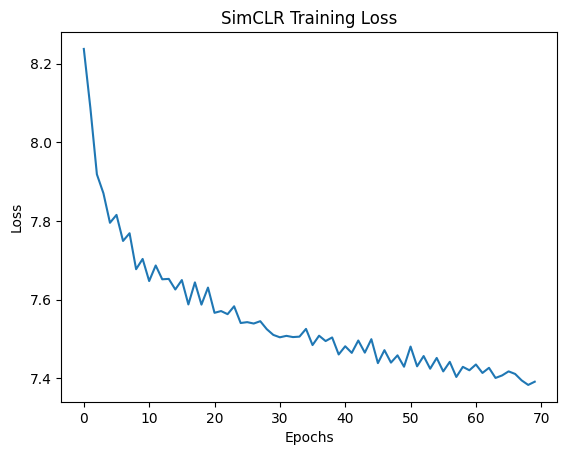

In [34]:
# plot la loss
import matplotlib.pyplot as plt
plt.plot(ssl_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("SimCLR Training Loss")
plt.savefig("./simclr_loss.png")

import json
with open('./simclr_losses_values.json','w') as f:
    json.dump({'loss_values' : ssl_losses},f)

# Step 3: Evaluate on the down-stream task: Train a new MLP decoder based on the trained encoder.

This finetune process should be way faster than the previous one. The expected Top-1 accuracy should be around 57% and the Top-5 accuracy should be around 97%. Getting this results is normal because linear prob is just a projection layer usually recognized as not having representation ability. To achieve the performance mentioned in the paper, we need larger dataset and more powerful GPU and longer time (about 1000 epoches during the pretraining stage).

In [7]:
class linear_prob_Trainer:
    def __init__(self, *args, **kwargs):
        self.args = kwargs["args"]
        self.model = kwargs["model"].to(self.args.device)
        self.optimizer = kwargs["optimizer"]
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.device)
        self.train_dataset = datasets.STL10(
            "./data", split="train", download=True, transform=transforms.ToTensor()
        )

        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

        self.test_dataset = datasets.STL10(
            "./data", split="test", download=True, transform=transforms.ToTensor()
        )

        self.test_loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.args.batch_size,
            num_workers=1,
            drop_last=False,
        )

    def accuracy(self, output, target, topk=(1,)):
        with torch.no_grad():
            maxk = max(topk)
            batch_size = target.size(0)

            _, pred = output.topk(maxk, 1, True, True)
            pred = pred.t()
            correct = pred.eq(target.view(1, -1).expand_as(pred))

            res = []
            for k in topk:
                correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
                res.append(correct_k.mul_(100.0 / batch_size))
            return res

    def train(self, dataloader):
        for epoch in range(100):
            top1_train_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_train_accuracy += top1[0]

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                print(
                    f"Epoch: {epoch}, Loss: {loss.item()}",
                    "Top1 Train Accuracy: ",
                    top1_train_accuracy.item() / len(dataloader),
                )
        return self.model

    def test(self, dataloader):
        with torch.no_grad():
            model.eval()
            top1_test_accuracy = 0
            top5_test_accuracy = 0
            for images, labels in tqdm(dataloader):
                images, labels = images.to(self.args.device), labels.to(
                    self.args.device
                )
                logits = self.model(images)
                top1 = self.accuracy(logits, labels, topk=(1,))
                top1_test_accuracy += top1[0]
                top5 = self.accuracy(logits, labels, topk=(5,))
                top5_test_accuracy += top5[0]
            print("Top1 Test Accuracy: ", top1_test_accuracy.item() / len(dataloader))
            print("Top5 Test Accuracy: ", top5_test_accuracy.item() / len(dataloader))
            return

# load your model here if you need to resume
folder = Path("./")
best_model_path = list(folder.rglob("best_*.pth"))[0]
print(f"Loading  best model from {best_model_path} for linear probe")
model.load_state_dict(torch.load(best_model_path), strict=False)


model.linear_probe()
linear_probe_optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
linear_prob_trainer = linear_prob_Trainer(args=args, model=model, optimizer=linear_probe_optimizer)
model = linear_prob_trainer.train(linear_prob_trainer.train_loader)
linear_prob_trainer.test(linear_prob_trainer.test_loader)

Loading  best model from best_model.pth for linear probe
Files already downloaded and verified
Files already downloaded and verified


 50%|█████     | 1/2 [00:02<00:02,  2.51s/it]

Epoch: 0, Loss: 2.4205362796783447 Top1 Train Accuracy:  4.19921875


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 0, Loss: 2.3619937896728516 Top1 Train Accuracy:  8.29672908782959


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 1, Loss: 2.317718505859375 Top1 Train Accuracy:  5.4524736404418945


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Epoch: 1, Loss: 2.2680914402008057 Top1 Train Accuracy:  11.13193416595459


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 2, Loss: 2.229013681411743 Top1 Train Accuracy:  7.9427080154418945


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 2, Loss: 2.1862740516662598 Top1 Train Accuracy:  16.5267333984375


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 3, Loss: 2.1515939235687256 Top1 Train Accuracy:  10.83984375


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 3, Loss: 2.1139907836914062 Top1 Train Accuracy:  21.991294860839844


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 4, Loss: 2.082754135131836 Top1 Train Accuracy:  12.776692390441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 4, Loss: 2.04878306388855 Top1 Train Accuracy:  26.39183807373047


 50%|█████     | 1/2 [00:02<00:02,  2.25s/it]

Epoch: 5, Loss: 2.0201761722564697 Top1 Train Accuracy:  14.404295921325684


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 5, Loss: 1.9887564182281494 Top1 Train Accuracy:  30.068195343017578


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 6, Loss: 1.9622503519058228 Top1 Train Accuracy:  15.901692390441895


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 6, Loss: 1.9327598810195923 Top1 Train Accuracy:  32.966007232666016


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 7, Loss: 1.9081106185913086 Top1 Train Accuracy:  17.15494728088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 7, Loss: 1.880285620689392 Top1 Train Accuracy:  35.38627624511719


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 8, Loss: 1.857435703277588 Top1 Train Accuracy:  18.27799415588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 8, Loss: 1.8312232494354248 Top1 Train Accuracy:  38.065338134765625


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 9, Loss: 1.810184121131897 Top1 Train Accuracy:  19.173175811767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 9, Loss: 1.7856017351150513 Top1 Train Accuracy:  39.842262268066406


 50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

Epoch: 10, Loss: 1.7663644552230835 Top1 Train Accuracy:  20.21484375


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 10, Loss: 1.743410587310791 Top1 Train Accuracy:  41.817543029785156


 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

Epoch: 11, Loss: 1.725904107093811 Top1 Train Accuracy:  21.06119728088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 11, Loss: 1.704514980316162 Top1 Train Accuracy:  43.51970291137695


 50%|█████     | 1/2 [00:02<00:02,  2.17s/it]

Epoch: 12, Loss: 1.6886128187179565 Top1 Train Accuracy:  21.84244728088379


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Epoch: 12, Loss: 1.6686681509017944 Top1 Train Accuracy:  44.741825103759766


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 13, Loss: 1.6542195081710815 Top1 Train Accuracy:  22.33072853088379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 13, Loss: 1.635567545890808 Top1 Train Accuracy:  45.82658004760742


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 14, Loss: 1.6224416494369507 Top1 Train Accuracy:  22.96549415588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 14, Loss: 1.6049244403839111 Top1 Train Accuracy:  46.69474792480469


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 15, Loss: 1.5930336713790894 Top1 Train Accuracy:  23.421222686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 15, Loss: 1.5765010118484497 Top1 Train Accuracy:  47.487613677978516


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 16, Loss: 1.5658048391342163 Top1 Train Accuracy:  23.811847686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 16, Loss: 1.5501137971878052 Top1 Train Accuracy:  48.474708557128906


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 17, Loss: 1.540603756904602 Top1 Train Accuracy:  24.251300811767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 17, Loss: 1.5256130695343018 Top1 Train Accuracy:  49.30316925048828


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 18, Loss: 1.5172944068908691 Top1 Train Accuracy:  24.544269561767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 18, Loss: 1.5028613805770874 Top1 Train Accuracy:  49.82954025268555


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 19, Loss: 1.4957364797592163 Top1 Train Accuracy:  24.837238311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 19, Loss: 1.4817235469818115 Top1 Train Accuracy:  50.61524963378906


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 20, Loss: 1.475783348083496 Top1 Train Accuracy:  25.0


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 20, Loss: 1.4620646238327026 Top1 Train Accuracy:  50.985477447509766


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 21, Loss: 1.4572919607162476 Top1 Train Accuracy:  25.244138717651367


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Epoch: 21, Loss: 1.4437620639801025 Top1 Train Accuracy:  51.56675338745117


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 22, Loss: 1.4401311874389648 Top1 Train Accuracy:  25.472003936767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 22, Loss: 1.4267065525054932 Top1 Train Accuracy:  51.924285888671875


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 23, Loss: 1.4241877794265747 Top1 Train Accuracy:  25.732419967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 23, Loss: 1.4108036756515503 Top1 Train Accuracy:  52.392173767089844


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 24, Loss: 1.409364104270935 Top1 Train Accuracy:  25.960285186767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 24, Loss: 1.3959672451019287 Top1 Train Accuracy:  52.85343933105469


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 25, Loss: 1.395567536354065 Top1 Train Accuracy:  26.123044967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 25, Loss: 1.3821104764938354 Top1 Train Accuracy:  53.249603271484375


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 26, Loss: 1.3827089071273804 Top1 Train Accuracy:  26.155597686767578


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 26, Loss: 1.3691481351852417 Top1 Train Accuracy:  53.567420959472656


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 27, Loss: 1.370700716972351 Top1 Train Accuracy:  26.269529342651367


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 27, Loss: 1.356997013092041 Top1 Train Accuracy:  53.7591552734375


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 28, Loss: 1.3594633340835571 Top1 Train Accuracy:  26.399738311767578


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 28, Loss: 1.3455837965011597 Top1 Train Accuracy:  53.967166900634766


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 29, Loss: 1.34892737865448 Top1 Train Accuracy:  26.692707061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 29, Loss: 1.334845781326294 Top1 Train Accuracy:  54.46760559082031


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 30, Loss: 1.3390332460403442 Top1 Train Accuracy:  26.82291603088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 30, Loss: 1.3247287273406982 Top1 Train Accuracy:  54.70154571533203


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 31, Loss: 1.3297301530838013 Top1 Train Accuracy:  27.06705665588379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 31, Loss: 1.3151843547821045 Top1 Train Accuracy:  54.997554779052734


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 32, Loss: 1.3209701776504517 Top1 Train Accuracy:  27.278644561767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 32, Loss: 1.306167721748352 Top1 Train Accuracy:  55.18320846557617


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 33, Loss: 1.312708854675293 Top1 Train Accuracy:  27.343748092651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 33, Loss: 1.2976335287094116 Top1 Train Accuracy:  55.248313903808594


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 34, Loss: 1.3049033880233765 Top1 Train Accuracy:  27.425128936767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 34, Loss: 1.2895417213439941 Top1 Train Accuracy:  55.381561279296875


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 35, Loss: 1.2975150346755981 Top1 Train Accuracy:  27.571613311767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 35, Loss: 1.2818553447723389 Top1 Train Accuracy:  55.631778717041016


 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

Epoch: 36, Loss: 1.2905100584030151 Top1 Train Accuracy:  27.587888717651367


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 36, Loss: 1.274541974067688 Top1 Train Accuracy:  55.80365753173828


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 37, Loss: 1.2838584184646606 Top1 Train Accuracy:  27.685544967651367


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 37, Loss: 1.2675745487213135 Top1 Train Accuracy:  56.030982971191406


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 38, Loss: 1.2775331735610962 Top1 Train Accuracy:  27.685544967651367


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Epoch: 38, Loss: 1.2609272003173828 Top1 Train Accuracy:  56.10877990722656


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 39, Loss: 1.271509051322937 Top1 Train Accuracy:  27.766925811767578


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 39, Loss: 1.2545777559280396 Top1 Train Accuracy:  56.242027282714844


 50%|█████     | 1/2 [00:02<00:02,  2.15s/it]

Epoch: 40, Loss: 1.2657612562179565 Top1 Train Accuracy:  27.94596290588379


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 40, Loss: 1.2485055923461914 Top1 Train Accuracy:  56.446998596191406


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 41, Loss: 1.2602683305740356 Top1 Train Accuracy:  27.978513717651367


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 41, Loss: 1.2426921129226685 Top1 Train Accuracy:  56.40174865722656


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 42, Loss: 1.2550103664398193 Top1 Train Accuracy:  27.94596290588379


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 42, Loss: 1.2371201515197754 Top1 Train Accuracy:  56.39513397216797


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 43, Loss: 1.249969720840454 Top1 Train Accuracy:  28.04361915588379


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 43, Loss: 1.2317745685577393 Top1 Train Accuracy:  56.64839172363281


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 44, Loss: 1.2451311349868774 Top1 Train Accuracy:  28.076169967651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 44, Loss: 1.2266409397125244 Top1 Train Accuracy:  56.78467559814453


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 45, Loss: 1.2404807806015015 Top1 Train Accuracy:  28.14127540588379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 45, Loss: 1.221705436706543 Top1 Train Accuracy:  56.823848724365234


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 46, Loss: 1.2360073328018188 Top1 Train Accuracy:  28.14127540588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 46, Loss: 1.2169543504714966 Top1 Train Accuracy:  56.927581787109375


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 47, Loss: 1.2316993474960327 Top1 Train Accuracy:  28.14127540588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 47, Loss: 1.212375521659851 Top1 Train Accuracy:  57.0572509765625


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 48, Loss: 1.2275480031967163 Top1 Train Accuracy:  28.173826217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 48, Loss: 1.20795738697052 Top1 Train Accuracy:  57.14167022705078


 50%|█████     | 1/2 [00:02<00:02,  2.28s/it]

Epoch: 49, Loss: 1.2235437631607056 Top1 Train Accuracy:  28.271482467651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 49, Loss: 1.2036900520324707 Top1 Train Accuracy:  57.2652587890625


 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

Epoch: 50, Loss: 1.2196789979934692 Top1 Train Accuracy:  28.28775978088379


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 50, Loss: 1.19956374168396 Top1 Train Accuracy:  57.307472229003906


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 51, Loss: 1.215945839881897 Top1 Train Accuracy:  28.352863311767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 51, Loss: 1.1955710649490356 Top1 Train Accuracy:  57.32070541381836


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 52, Loss: 1.212336540222168 Top1 Train Accuracy:  28.401691436767578


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Epoch: 52, Loss: 1.191704511642456 Top1 Train Accuracy:  57.42140197753906


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 53, Loss: 1.20884370803833 Top1 Train Accuracy:  28.43424415588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 53, Loss: 1.1879574060440063 Top1 Train Accuracy:  57.453956604003906


 50%|█████     | 1/2 [00:02<00:02,  2.12s/it]

Epoch: 54, Loss: 1.2054603099822998 Top1 Train Accuracy:  28.48307228088379


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Epoch: 54, Loss: 1.1843243837356567 Top1 Train Accuracy:  57.632450103759766


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 55, Loss: 1.2021807432174683 Top1 Train Accuracy:  28.515623092651367


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 55, Loss: 1.1807998418807983 Top1 Train Accuracy:  57.665000915527344


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 56, Loss: 1.198998212814331 Top1 Train Accuracy:  28.662107467651367


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Epoch: 56, Loss: 1.1773780584335327 Top1 Train Accuracy:  57.86334991455078


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 57, Loss: 1.1959086656570435 Top1 Train Accuracy:  28.694660186767578


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 57, Loss: 1.1740546226501465 Top1 Train Accuracy:  57.921836853027344


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 58, Loss: 1.1929067373275757 Top1 Train Accuracy:  28.759763717651367


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 58, Loss: 1.1708240509033203 Top1 Train Accuracy:  58.01287841796875


 50%|█████     | 1/2 [00:02<00:02,  2.16s/it]

Epoch: 59, Loss: 1.1899882555007935 Top1 Train Accuracy:  28.792316436767578


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Epoch: 59, Loss: 1.1676819324493408 Top1 Train Accuracy:  58.07136154174805


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 60, Loss: 1.1871501207351685 Top1 Train Accuracy:  28.82486915588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 60, Loss: 1.1646238565444946 Top1 Train Accuracy:  58.20764923095703


 50%|█████     | 1/2 [00:02<00:02,  2.22s/it]

Epoch: 61, Loss: 1.1843878030776978 Top1 Train Accuracy:  28.87369728088379


100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


Epoch: 61, Loss: 1.1616454124450684 Top1 Train Accuracy:  58.308345794677734


 50%|█████     | 1/2 [00:02<00:02,  2.20s/it]

Epoch: 62, Loss: 1.1816986799240112 Top1 Train Accuracy:  28.92252540588379


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Epoch: 62, Loss: 1.158743143081665 Top1 Train Accuracy:  58.434974670410156


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 63, Loss: 1.1790796518325806 Top1 Train Accuracy:  28.987628936767578


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 63, Loss: 1.1559134721755981 Top1 Train Accuracy:  58.50007629394531


 50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

Epoch: 64, Loss: 1.1765269041061401 Top1 Train Accuracy:  29.036457061767578


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Epoch: 64, Loss: 1.1531530618667603 Top1 Train Accuracy:  58.522972106933594


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 65, Loss: 1.1740375757217407 Top1 Train Accuracy:  29.036457061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 65, Loss: 1.1504592895507812 Top1 Train Accuracy:  58.65264129638672


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 66, Loss: 1.17160964012146 Top1 Train Accuracy:  29.036457061767578


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 66, Loss: 1.1478290557861328 Top1 Train Accuracy:  58.75637435913086


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 67, Loss: 1.1692396402359009 Top1 Train Accuracy:  29.036457061767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 67, Loss: 1.1452596187591553 Top1 Train Accuracy:  58.730438232421875


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 68, Loss: 1.166925072669983 Top1 Train Accuracy:  29.003904342651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 68, Loss: 1.1427488327026367 Top1 Train Accuracy:  58.77568817138672


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 69, Loss: 1.1646645069122314 Top1 Train Accuracy:  29.085285186767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 69, Loss: 1.1402943134307861 Top1 Train Accuracy:  58.85707092285156


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 70, Loss: 1.1624547243118286 Top1 Train Accuracy:  29.134113311767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 70, Loss: 1.1378939151763916 Top1 Train Accuracy:  58.957763671875


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 71, Loss: 1.1602941751480103 Top1 Train Accuracy:  29.101560592651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 71, Loss: 1.1355446577072144 Top1 Train Accuracy:  58.977081298828125


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 72, Loss: 1.158181071281433 Top1 Train Accuracy:  29.101560592651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 72, Loss: 1.1332454681396484 Top1 Train Accuracy:  59.02894592285156


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 73, Loss: 1.156113862991333 Top1 Train Accuracy:  29.101560592651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 73, Loss: 1.1309937238693237 Top1 Train Accuracy:  58.95114517211914


 50%|█████     | 1/2 [00:02<00:02,  2.25s/it]

Epoch: 74, Loss: 1.1540900468826294 Top1 Train Accuracy:  29.16666603088379


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Epoch: 74, Loss: 1.1287877559661865 Top1 Train Accuracy:  58.990318298339844


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 75, Loss: 1.1521086692810059 Top1 Train Accuracy:  29.199216842651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 75, Loss: 1.1266261339187622 Top1 Train Accuracy:  59.074737548828125


 50%|█████     | 1/2 [00:02<00:02,  2.26s/it]

Epoch: 76, Loss: 1.1501675844192505 Top1 Train Accuracy:  29.199216842651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 76, Loss: 1.1245070695877075 Top1 Train Accuracy:  59.100669860839844


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 77, Loss: 1.1482653617858887 Top1 Train Accuracy:  29.182941436767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 77, Loss: 1.1224291324615479 Top1 Train Accuracy:  59.0584602355957


 50%|█████     | 1/2 [00:02<00:02,  2.38s/it]

Epoch: 78, Loss: 1.146401286125183 Top1 Train Accuracy:  29.231769561767578


100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


Epoch: 78, Loss: 1.1203910112380981 Top1 Train Accuracy:  59.1072883605957


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 79, Loss: 1.1445732116699219 Top1 Train Accuracy:  29.248044967651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 79, Loss: 1.118390679359436 Top1 Train Accuracy:  59.17543029785156


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 80, Loss: 1.142780065536499 Top1 Train Accuracy:  29.248044967651367


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Epoch: 80, Loss: 1.1164273023605347 Top1 Train Accuracy:  59.17543029785156


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 81, Loss: 1.1410207748413086 Top1 Train Accuracy:  29.231769561767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 81, Loss: 1.1144996881484985 Top1 Train Accuracy:  59.211021423339844


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 82, Loss: 1.1392940282821655 Top1 Train Accuracy:  29.26432228088379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 82, Loss: 1.112606406211853 Top1 Train Accuracy:  59.32137680053711


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 83, Loss: 1.1375987529754639 Top1 Train Accuracy:  29.280597686767578


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 83, Loss: 1.110746145248413 Top1 Train Accuracy:  59.41545104980469


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 84, Loss: 1.1359339952468872 Top1 Train Accuracy:  29.296873092651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 84, Loss: 1.1089181900024414 Top1 Train Accuracy:  59.457664489746094


 50%|█████     | 1/2 [00:02<00:02,  2.14s/it]

Epoch: 85, Loss: 1.1342982053756714 Top1 Train Accuracy:  29.36197853088379


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Epoch: 85, Loss: 1.1071213483810425 Top1 Train Accuracy:  59.54869842529297


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 86, Loss: 1.132691502571106 Top1 Train Accuracy:  29.394529342651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 86, Loss: 1.1053543090820312 Top1 Train Accuracy:  59.60718536376953


 50%|█████     | 1/2 [00:02<00:02,  2.33s/it]

Epoch: 87, Loss: 1.1311122179031372 Top1 Train Accuracy:  29.394529342651367


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Epoch: 87, Loss: 1.1036162376403809 Top1 Train Accuracy:  59.65904998779297


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 88, Loss: 1.1295597553253174 Top1 Train Accuracy:  29.443357467651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 88, Loss: 1.101906657218933 Top1 Train Accuracy:  59.785682678222656


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 89, Loss: 1.1280330419540405 Top1 Train Accuracy:  29.475910186767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 89, Loss: 1.1002240180969238 Top1 Train Accuracy:  59.818233489990234


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 90, Loss: 1.1265310049057007 Top1 Train Accuracy:  29.50846290588379


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 90, Loss: 1.0985679626464844 Top1 Train Accuracy:  59.8767204284668


 50%|█████     | 1/2 [00:02<00:02,  2.25s/it]

Epoch: 91, Loss: 1.1250534057617188 Top1 Train Accuracy:  29.50846290588379


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Epoch: 91, Loss: 1.0969375371932983 Top1 Train Accuracy:  59.90265655517578


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 92, Loss: 1.1235994100570679 Top1 Train Accuracy:  29.492185592651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 92, Loss: 1.0953316688537598 Top1 Train Accuracy:  59.834510803222656


 50%|█████     | 1/2 [00:02<00:02,  2.27s/it]

Epoch: 93, Loss: 1.1221681833267212 Top1 Train Accuracy:  29.541013717651367


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Epoch: 93, Loss: 1.0937504768371582 Top1 Train Accuracy:  59.883338928222656


 50%|█████     | 1/2 [00:02<00:02,  2.30s/it]

Epoch: 94, Loss: 1.1207586526870728 Top1 Train Accuracy:  29.60611915588379


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 94, Loss: 1.09219229221344 Top1 Train Accuracy:  59.9743766784668


 50%|█████     | 1/2 [00:02<00:02,  2.31s/it]

Epoch: 95, Loss: 1.1193708181381226 Top1 Train Accuracy:  29.65494728088379


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 95, Loss: 1.0906569957733154 Top1 Train Accuracy:  60.12693786621094


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 96, Loss: 1.1180037260055542 Top1 Train Accuracy:  29.671222686767578


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 96, Loss: 1.0891438722610474 Top1 Train Accuracy:  60.19508361816406


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 97, Loss: 1.1166568994522095 Top1 Train Accuracy:  29.687498092651367


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 97, Loss: 1.0876520872116089 Top1 Train Accuracy:  60.26322555541992


 50%|█████     | 1/2 [00:02<00:02,  2.32s/it]

Epoch: 98, Loss: 1.115329623222351 Top1 Train Accuracy:  29.720050811767578


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Epoch: 98, Loss: 1.0861810445785522 Top1 Train Accuracy:  60.2957763671875


 50%|█████     | 1/2 [00:02<00:02,  2.29s/it]

Epoch: 99, Loss: 1.1140214204788208 Top1 Train Accuracy:  29.736326217651367


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Epoch: 99, Loss: 1.0847302675247192 Top1 Train Accuracy:  60.389854431152344


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Top1 Test Accuracy:  58.054951985677086
Top5 Test Accuracy:  97.21848551432292
